<span style="font-size:18px; color:red; font-weight:bold">Churn Bancario, aplicamos un modelo de ML (Random Forest) desarrollado en Python a nuestra cartera de clientes para predecir la probabilidad de churn</span>

**Enrique Aranaz Tudela**

LInkedin: www.linkedin.com/in/enrique-aranaz-tudela

En este Notebook desarrollado en un Lakehouse de Microsoft Fabric aplicaremos un modelo de Machine Learning desarrollado sobre la Tabla Customers para imputar la probabilidad de churn a los clientes de cartera del Banco. 

StatementMeta(, bb989772-0d8d-4d77-aa27-d5ef406542d6, 6, Finished, Available, Finished)

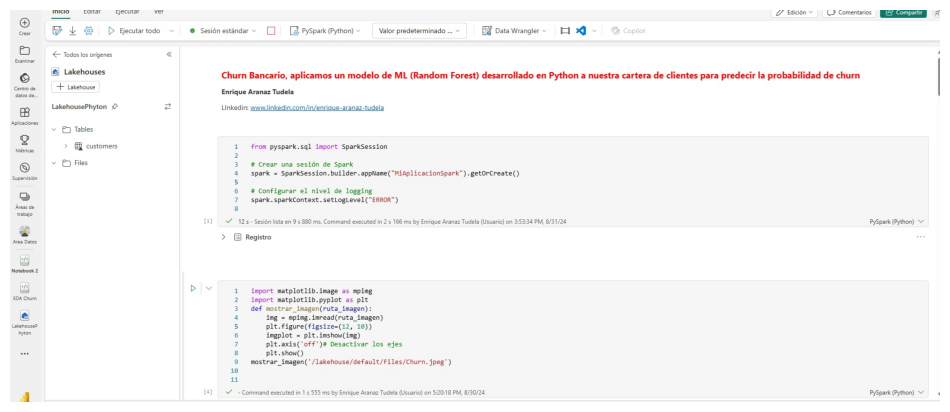

In [4]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("MiAplicacionSpark").getOrCreate()

# Configurar el nivel de logging
spark.sparkContext.setLogLevel("ERROR")

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def mostrar_imagen(ruta_imagen):
    img = mpimg.imread(ruta_imagen)
    plt.figure(figsize=(12, 10))
    imgplot = plt.imshow(img)
    plt.axis('off')# Desactivar los ejes
    plt.show()

mostrar_imagen('/lakehouse/default/Files/FabricNotebook2.jpg')

StatementMeta(, a93cbd97-e174-44a9-a2db-e2dc24b1abf8, 6, Finished, Available, Finished)

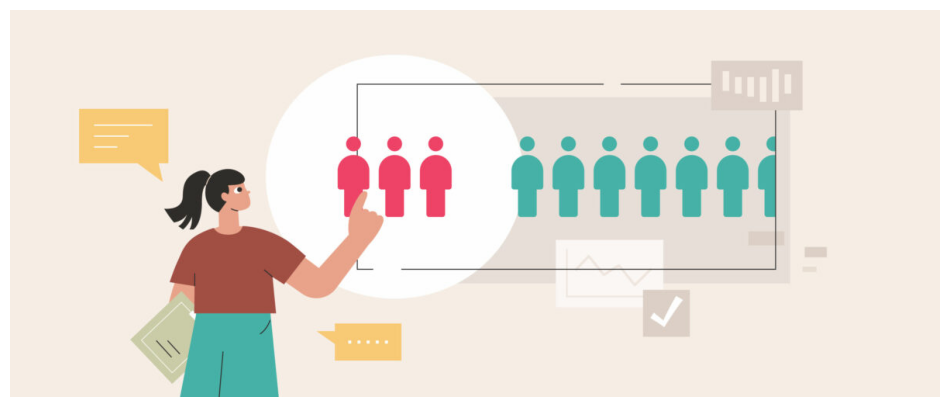

In [4]:

mostrar_imagen('/lakehouse/default/Files/Churn.jpeg')



<span style="font-size:18px; color:red; font-weight:bold">0. Importación de librerias a utilizar y definición de funciones</span>

In [5]:
# Librerias básicas:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pylab
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
from scipy.stats import shapiro, normaltest, kstest, jarque_bera
from scipy.stats import probplot
from scipy.stats import stats
from scipy.stats import mstats

# Feature Selection, Preprocesado, Modelos, Métricas, GridSearch:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
!pip install mlxtend
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits


import warnings
warnings.filterwarnings("ignore")


StatementMeta(, bb989772-0d8d-4d77-aa27-d5ef406542d6, 7, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.3 MB/s eta 0:00:00a 0:00:01


<span style="font-size:18px; color:red; font-weight:bold">1. Carga de la Tabla Customers</span>

In [6]:
# Load data into pandas DataFrame from "/lakehouse/default/Files/Customer-Churn-Records.csv"
#df = pd.read_csv("/lakehouse/default/Files/Customer-Churn-Records.csv")

#Cargamos datos de Customer
df_spark = spark.sql("SELECT * FROM LakehousePhyton.customers")
display(df_spark)

print(type(df_spark))

# Convertir el DataFrame de PySpark a un DataFrame de pandas
df = df_spark.toPandas()

# Verificar el tipo para asegurarte de que es un DataFrame de pandas
print(type(df))

StatementMeta(, bb989772-0d8d-4d77-aa27-d5ef406542d6, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b023eb4f-c2cd-4d24-9706-9493739fff1a)

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


<span style="font-size:18px; color:red; font-weight:bold">2. Ejecutar Modelo Random Forest y calcular las probabilidades obtenidas por el modelo al dataset </span>

In [7]:
# Primero codificamos las variables categoricas 

#Codificación One-hot para las variables 'Geography' y 'Card Type'
df= pd.get_dummies(df, columns=['Geography', 'Card_Type'], drop_first=True)

# Codificación de etiquetas para la variable 'Gender'
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

# Seleccionamos las features que vamos a usar en nuestro entrenamiento, descartando las no significativas
selected_features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Point_Earned', 'Geography_Germany','Geography_Spain' ]

# Predecir probabilidades y añadirlas al df

X= df[selected_features]
y= df['Exited']

#Aplicación RandomOverSampler para correfgir desequilibrio
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Aplicar RandomOverSampler solo al conjunto de entrenamiento
rand_over_samp = RandomOverSampler(random_state=42)
X_train, y_train = rand_over_samp.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.transform(X)  # Escalar todo el DataFrame

modelo = RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=20, min_samples_leaf=10, n_estimators=200, random_state=42)
modelo.fit(scaled_X_train, y_train)

# Predecir probabilidades sobre todo el DataFrame
y_prob = modelo.predict_proba(scaled_X)[:, 1]  # Probabilidad de la clase 1

# Añadir las probabilidades al DataFrame original
df['Probabilidad_Exit'] = y_prob
df['Exited_pred'] = df['Probabilidad_Exit'].apply(lambda x: 1 if x > 0.5 else 0)

StatementMeta(, bb989772-0d8d-4d77-aa27-d5ef406542d6, 9, Finished, Available, Finished)

2024-08-31:13:59:01,755 WARNING  [tracking_store.py:153] log_inputs not supported


StatementMeta(, bb989772-0d8d-4d77-aa27-d5ef406542d6, 10, Finished, Available, Finished)

2024-08-31:13:59:23,689 WARNING  [tracking_store.py:153] log_inputs not supported


              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2397
           1       0.53      0.68      0.60       603

    accuracy                           0.81      3000
   macro avg       0.72      0.76      0.74      3000
weighted avg       0.84      0.81      0.82      3000



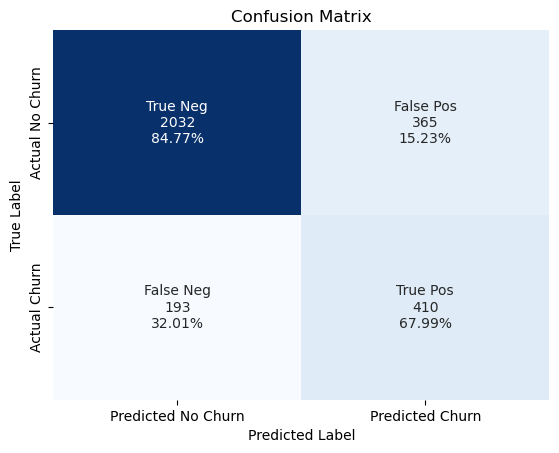

2024-08-31:13:59:26,684 WARNING  [tracking_store.py:153] log_inputs not supported


Accuracy: 0.814
Recall: 0.68
f1_score: 0.595
Precision: 0.529


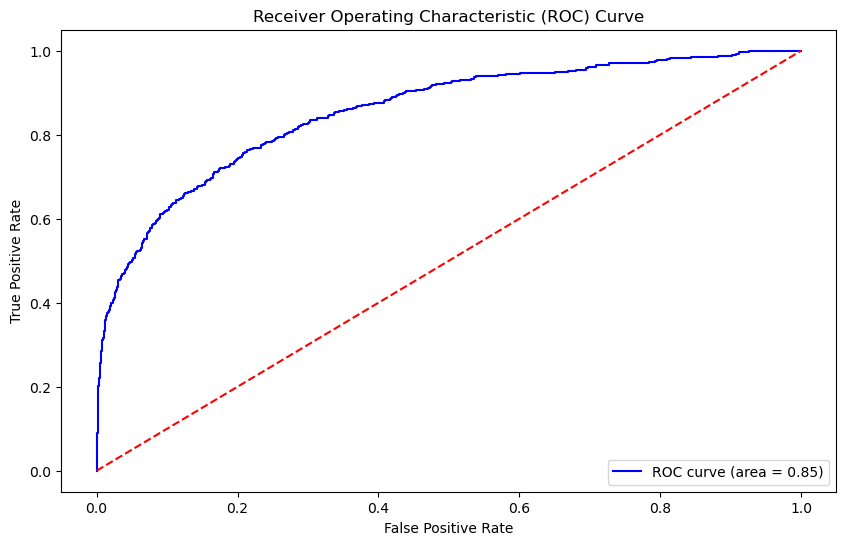

In [8]:
def evaluationModel(y_test, y_pred):
    # Calcular la matriz de confusión
    cn = confusion_matrix(y_test, y_pred)
    
    # Calcular el porcentaje de cada celda sobre el total de la fila
    cn_percent = cn / cn.sum(axis=1, keepdims=True) * 100
    
    # Nombres personalizados para las celdas
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    # Crear anotaciones combinadas de nombres, números absolutos y porcentajes
    combined_labels = np.array([f'{name}\n{value}\n{percent:.2f}%' for name, value, percent in zip(names, cn.flatten(), cn_percent.flatten())]).reshape(2, 2)
    
    # Crear el heatmap
    sns.heatmap(cn, annot=combined_labels, fmt='', cmap='Blues', cbar=False, xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
    
    # Añadir etiquetas y título
    plt.xlabel('Predicted Label')  
    plt.ylabel('True Label')  
    plt.title('Confusion Matrix') 
    plt.show()


# Calcular las predicciones para el conjunto de prueba
y_pred = modelo.predict(scaled_X_test)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))
evaluationModel(y_test, y_pred)

accuracy = round(accuracy_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("f1_score:", f1)
print("Precision:", precision)

# Calcular las probabilidades de predicción (no las binarias) para el conjunto de prueba
y_pred_proba = modelo.predict_proba(scaled_X_test)[:, 1]

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<span style="font-size:18px; color:red; font-weight:bold">3. Añadir probabilidades de Churn y predicción a la Tabla Customers </span>

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.sql.types import IntegerType

# Seleccionar solo las columnas necesarias del DataFrame de pandas
df_selected = df[['CustomerId', 'Probabilidad_Exit', 'Exited_pred']]

# Convertir el DataFrame de pandas a un DataFrame de Spark
df_pandas_spark = spark.createDataFrame(df_selected)

# Verificar el DataFrame de pandas convertido
df_pandas_spark.show()

StatementMeta(, bb989772-0d8d-4d77-aa27-d5ef406542d6, 12, Finished, Available, Finished)

+----------+------------------+-----------+
|CustomerId| Probabilidad_Exit|Exited_pred|
+----------+------------------+-----------+
|  15625824|0.9226496802130084|          1|
|  15671591|0.9621282361119045|          1|
|  15764431|0.8936402119714825|          1|
|  15654562|0.9114068302364658|          1|
|  15608338|0.9781847143741065|          1|
|  15610383|0.9497184542405505|          1|
|  15603851|0.9276347795300911|          1|
|  15704442|0.9650346027908703|          1|
|  15634974|0.7935737381276945|          1|
|  15679770|0.9592184131607147|          1|
|  15724161|0.9481406562900133|          1|
|  15750778|0.9737413769133149|          1|
|  15601594|0.9702746868136913|          1|
|  15668283|0.9344778283960725|          1|
|  15665283|0.9575702467467246|          1|
|  15648681|0.9596373127894935|          1|
|  15673591|0.9020352827099155|          1|
|  15681007|0.9266520652183868|          1|
|  15633194|0.9388580462919469|          1|
|  15599329|0.9645497439117576| 

In [11]:
# Realizar el join en el campo CustomerId
df_combined = df_spark.join(df_pandas_spark, on="CustomerId", how="left")

# Convertir el DataFrame de Spark a un DataFrame de pandas
df_pandas = df_combined.toPandas()

# Guardar el DataFrame como un archivo Parquet y sobrescribir el archivo existente
df_pandas.to_parquet("/lakehouse/default/Files/Customers_updated.parquet", index=False)
df_pandas

StatementMeta(, bb989772-0d8d-4d77-aa27-d5ef406542d6, 13, Finished, Available, Finished)

,CustomerId,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction_Score,Card_Type,Point_Earned,Probabilidad_Exit,Exited_pred
0,15625824,1489,Kornilova,596,Spain,Male,30,6,121345.88,4,1,0,41921.75,1,1,2,SILVER,317,0.922650,1
1,15671591,2873,Castiglione,439,Spain,Male,52,3,96196.24,4,1,0,198874.52,1,1,1,GOLD,397,0.962128,1
2,15764431,3366,Chinwenma,671,Spain,Female,34,5,130929.02,4,1,1,28238.25,1,1,1,PLATINUM,586,0.893640,1
3,15654562,4167,Ma,850,Spain,Female,45,5,174088.30,4,1,0,5669.31,1,1,1,GOLD,240,0.911407,1
4,15608338,6280,Chiemenam,757,Spain,Female,55,9,117294.12,4,1,0,94187.47,1,1,2,DIAMOND,918,0.978185,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15765345,8833,Wood,753,France,Male,35,4,0.00,2,1,1,106303.40,0,0,2,GOLD,759,0.046316,0
9996,15723400,9024,Hutchinson,663,France,Male,28,4,0.00,2,1,1,123969.64,0,0,2,PLATINUM,540,0.060868,0
9997,15603883,9746,Ch'in,818,France,Male,36,4,0.00,2,1,1,8037.03,0,0,2,GOLD,266,0.067631,0
9998,15698462,9774,Chiu,532,France,Male,36,4,0.00,2,1,1,132798.78,0,0,2,GOLD,726,0.058319,0
